<a href="https://colab.research.google.com/github/gvescape/NeuralNetworkCompression/blob/main/Neural_Network_Compression_CP3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installing and importing required modules

In [1]:
!pip install ipython-autotime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 9.8 MB/s eta 0:00:00


In [2]:
!pip install torch_pruning==0.2.6

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn as nn
from torchvision import models,transforms,datasets
import torch.nn.utils.prune as prune
from copy import deepcopy
import torch_pruning as tp

# To time everything
%load_ext autotime

time: 334 µs (started: 2023-09-16 01:05:29 +00:00)


In [4]:
# Setting up GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

time: 148 ms (started: 2023-09-16 01:05:29 +00:00)


# Import CIFAR-100 and Resize

In [5]:
# Transforming the CIFAR100 train dataset and test dataset
train_transform = transforms.Compose([transforms.Resize(64),
                                   transforms.RandomHorizontalFlip(),
                                   transforms.RandomRotation(15),
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.48,0.4593,0.4155),(0.2774,0.2794,0.2794))])

test_transform = transforms.Compose([transforms.Resize(64),
                                  transforms.ToTensor(),
                                  transforms.Normalize((0.48,0.4593,0.4155),(0.2774,0.2794,0.2794))])

time: 12.3 ms (started: 2023-09-16 01:05:30 +00:00)


In [6]:
train_data_set = datasets.CIFAR100(root = "CIFAR100", train = True, download = True, transform = train_transform)

100%|██████████| 169001437/169001437 [00:03<00:00, 42488150.03it/s]


Extracting CIFAR100/cifar-100-python.tar.gz to CIFAR100
time: 10 s (started: 2023-09-16 01:05:30 +00:00)


In [7]:
test_data_set = datasets.CIFAR100(root = "CIFAR100", train = False, download = True, transform = test_transform)

Files already downloaded and verified
time: 1.02 s (started: 2023-09-16 01:05:40 +00:00)


In [8]:
train_data_set[0][0].shape

torch.Size([3, 64, 64])

time: 125 ms (started: 2023-09-16 01:05:41 +00:00)


In [9]:
test_data_set[0][0].shape

torch.Size([3, 64, 64])

time: 9.74 ms (started: 2023-09-16 01:05:41 +00:00)


# VGG16

In [10]:
# Defining number of classes in the dataset
n_classes = 100

# Defining the Batch size for training
batch_size = 64

# Defining Number of epochs
n_epochs = 15

time: 765 µs (started: 2023-09-16 01:05:41 +00:00)


In [11]:
vgg16_model = models.vgg16(pretrained = True) #130million+ parameters

# set_parameter_requires_grad for classifier layers
'''
for param in vgg16_model.parameters():
  param.requires_grad=False
'''

# Modifying last layer out classes
vgg16_model.classifier[6].out_features = n_classes

vgg16_model = vgg16_model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:05<00:00, 108MB/s] 


time: 12.9 s (started: 2023-09-16 01:05:41 +00:00)


In [12]:
# Printing VGG16 Model
print(vgg16_model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

# Training

In [13]:
# To compute the cross entropy loss between input and target
criterion = nn.CrossEntropyLoss()

# To implement stochastic gradient descent and optimize the model
sgd_optimizer = optim.SGD(vgg16_model.parameters(), lr = 0.003, momentum = 0.9)

# Decays the learning rate of each parameter group by gamma every step_size epochs
lr_scheduler = optim.lr_scheduler.StepLR(sgd_optimizer, step_size = 15, gamma = 0.1)

# Defining a 'DataLoader' constructor, a Python iterable over a dataset
train_dataloader  = DataLoader(train_data_set, batch_size = batch_size, shuffle = True)
test_dataloader   = DataLoader(test_data_set, batch_size = batch_size, shuffle = True)

time: 1.71 ms (started: 2023-09-16 01:05:54 +00:00)


In [14]:
# Method to train the model
def fit(model, dataset, optimizer, scheduler, criterion):
  # Set model to training mode
  model.train()
  if scheduler != None:
    scheduler.step()
  # Iterating over the data
  for data, targets in dataset:
    data    = data.to(device)
    targets = targets.to(device)
    # Reset the gradients
    optimizer.zero_grad()
    # Generate predictions
    pred  = model(data)
    # Calculate loss
    loss  = criterion(pred, targets)
    # Backpropagation
    loss.backward()
    # Update model parameters
    optimizer.step()

time: 742 µs (started: 2023-09-16 01:05:54 +00:00)


In [15]:
from os import pread
# Method to validate the model
def validate(model, dataset, criterion):
  # Set model to evaluation mode
  model.eval()
  accuracy  = 0
  loss      = []
  for data, targets in dataset:
    data    = data.to(device)
    targets = targets.to(device)
    pred    = model(data)
    # Get loss
    l = criterion(pred, targets)
    loss.append(l.item())
    # Get index of class label
    _,preds = torch.max(pred.data,1)
    # Get accuracy
    accuracy += torch.sum(preds == targets).item()

  return 100*accuracy/len(dataset.dataset), np.mean(np.array(loss))

time: 1.06 ms (started: 2023-09-16 01:05:54 +00:00)


In [16]:
train_loss  = []
train_acc   = []
test_loss   = []
test_acc    = []
epochs      = []
epoch_value = 0

# Loop for n_epochs
for epoch in range(n_epochs):
  # Fit model
  fit(vgg16_model, train_dataloader, sgd_optimizer, lr_scheduler, criterion)

  # Train validation
  train_accuracy, train_lss = validate(vgg16_model, train_dataloader, criterion)
  train_loss.append(train_lss)
  train_acc.append(train_accuracy)

  # Test validation
  test_accuracy, test_lss = validate(vgg16_model, test_dataloader, criterion)
  test_loss.append(test_lss)
  test_acc.append(test_accuracy)

  # Printing the epochs with
  print(f'Epoch:{epoch+1:2.0f}\t Train_Loss:{train_loss[-1]:.4f}\t Train_Acc:{train_acc[-1]:.4f}\t Test_Loss:{test_loss[-1]:.4f}\t Test_Acc:{test_acc[-1]:.4f}')
  epoch_value +=1
  epochs.append(epoch_value)


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Epoch: 1	 Train_Loss:2.5240	 Train_Acc:31.9760	 Test_Loss:2.5345	 Test_Acc:31.6500
Epoch: 2	 Train_Loss:1.7365	 Train_Acc:51.0180	 Test_Loss:1.7924	 Test_Acc:49.8900
Epoch: 3	 Train_Loss:1.3029	 Train_Acc:62.2120	 Test_Loss:1.4317	 Test_Acc:59.7700
Epoch: 4	 Train_Loss:1.1139	 Train_Acc:67.4840	 Test_Loss:1.2697	 Test_Acc:63.5400
Epoch: 5	 Train_Loss:0.9988	 Train_Acc:70.5940	 Test_Loss:1.2312	 Test_Acc:65.1700
Epoch: 6	 Train_Loss:0.8610	 Train_Acc:74.1280	 Test_Loss:1.1853	 Test_Acc:66.8800
Epoch: 7	 Train_Loss:0.7129	 Train_Acc:78.5580	 Test_Loss:1.1148	 Test_Acc:68.7300
Epoch: 8	 Train_Loss:0.6703	 Train_Acc:79.5180	 Test_Loss:1.1000	 Test_Acc:69.3400
Epoch: 9	 Train_Loss:0.5760	 Train_Acc:82.4400	 Test_Loss:1.0781	 Test_Acc:70.6300
Epoch:10	 Train_Loss:0.5318	 Train_Acc:83.7880	 Test_Loss:1.0967	 Test_Acc:70.4300
Epoch:11	 Train_Loss:0.5091	 Train_Acc:84.1840	 Test_Loss:1.1140	 Test_Acc:70.4100
Epoch:12	 Train_Loss:0.4692	 Train_Acc:85.5220	 Test_Loss:1.1428	 Test_Acc:70.2600
Epoc

Test Loss:  [2.5344692142146408, 1.7924078604218308, 1.4316893588205812, 1.2696979364771752, 1.231214082165129, 1.1853279338520804, 1.11478802922425, 1.0999776519787539, 1.0780926677072125, 1.096722681431254, 1.1140102406216275, 1.1427601718219222, 1.094259397998737, 1.1609036159363522, 1.0493473532093558]
Epochs:  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]


Text(0.5, 0, 'Test Loss')

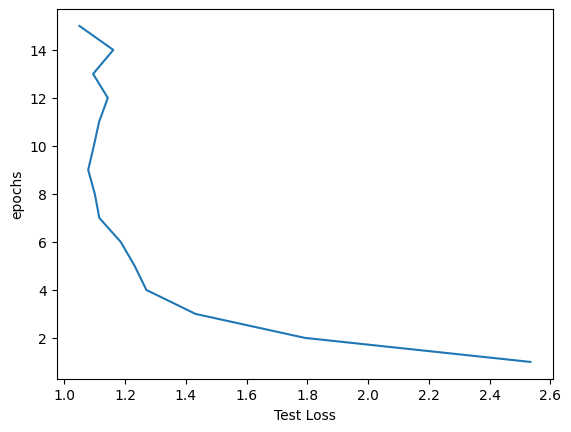

time: 245 ms (started: 2023-09-16 01:41:07 +00:00)


In [17]:
# Plotting Epoch vs Test Loss
print('Test Loss: ', test_loss)
print('Epochs: ', epochs)

plt.plot(test_loss, epochs)
plt.ylabel('epochs')
plt.xlabel('Test Loss')

# Save VGG16 Model

In [18]:
# # Authorizing Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive
time: 11min 23s (started: 2023-09-16 01:41:07 +00:00)


In [19]:
# # Saving the model to Drive
path = F"VGG16(SGD)-v1.0"
torch.save(vgg16_model.state_dict(), path)

time: 1.94 s (started: 2023-09-16 01:52:31 +00:00)


In [20]:
# # Checking the GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda
time: 1.65 ms (started: 2023-09-16 01:52:33 +00:00)


# Important Functions

In [21]:
# Method to remove parameters
def remove_parameters(model):
    for module_name, module in model.named_modules():
        if isinstance(module, torch.nn.Conv2d):
            try:
                prune.remove(module, "weight")
            except:
                pass
            try:
                prune.remove(module, "bias")
            except:
                pass
        elif isinstance(module, torch.nn.Linear):
            try:
                prune.remove(module, "weight")
            except:
                pass
            try:
                prune.remove(module, "bias")
            except:
                pass
    return model

time: 645 µs (started: 2023-09-16 01:52:33 +00:00)


In [22]:
# Method for unstructured pruning
def unstructured_global_pruning(model, amount):
  pruning_model = deepcopy(model)
  pruning_model = pruning_model.to(device)

  parameters_to_prune = []
  for module_name, module in pruning_model.named_modules():
      if isinstance(module, torch.nn.Conv2d) or isinstance(module, torch.nn.Linear):
          parameters_to_prune.append((module, "weight"))

  prune.global_unstructured(
      parameters = parameters_to_prune,
      pruning_method = prune.L1Unstructured,
      amount = amount)

  pruning_model = remove_parameters(model = pruning_model)

  return pruning_model

time: 658 µs (started: 2023-09-16 01:52:33 +00:00)


In [23]:
# Method to evaluated the loss and accuracy of the model
def evaluate(model, dataloader):
  model.eval()
  acc = 0
  loss = []
  for data, targets in dataloader:
    data = data.to(device)
    targets = targets.to(device)
    out = model(data)
    #Get loss
    l = criterion(out, targets)
    loss.append(l.item())
    #Get index of class label
    _,preds = torch.max(out.data,1)
    #Get accuracy
    acc += torch.sum(preds == targets).item()

  return 100*acc/len(dataloader.dataset), np.mean(np.array(loss))

time: 470 µs (started: 2023-09-16 01:52:33 +00:00)


In [24]:
# Method to measure module sparsity
def measure_module_sparsity(module, weight=True, bias=False, use_mask=False):
    n_zeros = 0
    n_elements = 0
    if use_mask == True:
        for buffer_name, buffer in module.named_buffers():
            if "weight_mask" in buffer_name and weight == True:
                n_zeros += torch.sum(buffer == 0).item()
                n_elements += buffer.nelement()
            if "bias_mask" in buffer_name and bias == True:
                n_zeros += torch.sum(buffer == 0).item()
                n_elements += buffer.nelement()
    else:
        for param_name, param in module.named_parameters():
            if "weight" in param_name and weight == True:
                n_zeros += torch.sum(param == 0).item()
                n_elements += param.nelement()
            if "bias" in param_name and bias == True:
                n_zeros += torch.sum(param == 0).item()
                n_elements += param.nelement()

    sparsity = n_zeros / n_elements

    return n_zeros, n_elements, sparsity

time: 759 µs (started: 2023-09-16 01:52:33 +00:00)


In [25]:
# Method to measure Global sparsity
def measure_global_sparsity(model,
                            weight=True,
                            bias=False,
                            conv2d_use_mask=False,
                            linear_use_mask=False):

    n_zeros = 0
    n_elements = 0

    for module_name, module in model.named_modules():

        if isinstance(module, torch.nn.Conv2d):

            module_num_zeros, module_num_elements, _ = measure_module_sparsity(
                module, weight=weight, bias=bias, use_mask=conv2d_use_mask)
            n_zeros += module_num_zeros
            n_elements += module_num_elements

        elif isinstance(module, torch.nn.Linear):

            module_num_zeros, module_num_elements, _ = measure_module_sparsity(
                module, weight=weight, bias=bias, use_mask=linear_use_mask)
            n_zeros += module_num_zeros
            n_elements += module_num_elements

    sparsity = n_zeros / n_elements

    return n_zeros, n_elements, sparsity

time: 424 µs (started: 2023-09-16 01:52:33 +00:00)


In [26]:
# Defining a 'DataLoader' constructor, a Python iterable over a dataset
train_dataloader = DataLoader(train_data_set, batch_size = batch_size, shuffle = True)
test_dataloader = DataLoader(test_data_set, batch_size = batch_size)

time: 565 µs (started: 2023-09-16 01:52:33 +00:00)


# Import Model to be Pruned

In [27]:
vgg16_model = models.vgg16(pretrained = False)
vgg16_model.classifier[6].out_features = n_classes

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


time: 2.19 s (started: 2023-09-16 01:52:33 +00:00)


In [28]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
time: 756 ms (started: 2023-09-16 01:52:35 +00:00)


In [29]:
vgg16_model.load_state_dict(torch.load('VGG16(SGD)-v1.0'))

<All keys matched successfully>

time: 556 ms (started: 2023-09-16 01:52:36 +00:00)


In [30]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
vgg16_model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

time: 154 ms (started: 2023-09-16 01:52:37 +00:00)


In [31]:
next(vgg16_model.parameters()).is_cuda

True

time: 6.12 ms (started: 2023-09-16 01:52:37 +00:00)


In [32]:
# Measuring Global Sparsity for VGG16 Model
num_zeros, num_elements, sparsity = measure_global_sparsity(
            vgg16_model,
            weight=True,
            bias=False,
            conv2d_use_mask=False,
            linear_use_mask=False)

print("Global Sparsity:")
print("{:.2f}".format(sparsity))

Global Sparsity:
0.00
time: 16 ms (started: 2023-09-16 01:52:37 +00:00)


# Unstructured Pruning

In [33]:
ustp_model = unstructured_global_pruning(vgg16_model, 0.8)

time: 463 ms (started: 2023-09-16 01:52:37 +00:00)


In [34]:
next(ustp_model.parameters()).is_cuda

True

time: 2.7 ms (started: 2023-09-16 01:52:37 +00:00)


In [35]:
acc, loss = evaluate(ustp_model, test_dataloader)
print('Accuracy : ',acc , '\tLoss : ', loss)

Accuracy :  73.54 	Loss :  1.1236315794811127
time: 9.2 s (started: 2023-09-16 01:52:37 +00:00)


In [36]:
# Measuring Global Sparsity for Unstructured Pruning Model
num_zeros, num_elements, sparsity = measure_global_sparsity(
            ustp_model,
            weight  = True,
            bias    = False,
            conv2d_use_mask = False,
            linear_use_mask = False)

print("Global Sparsity:")
print("{:.2f}".format(sparsity))

Global Sparsity:
0.80
time: 17.7 ms (started: 2023-09-16 01:52:46 +00:00)


In [37]:
# Measuring Sparsity for each layer
sparsity_layer = []
i = 0
layer = []
for module_name, module in ustp_model.named_modules():
  if isinstance(module, torch.nn.Conv2d) or isinstance(module, torch.nn.Linear):
    num_zeros, num_elements, sparsity = measure_module_sparsity(module, weight=True, bias=False, use_mask=False)
    print('Layer', i , num_zeros, num_elements, sparsity)
    sparsity_layer.append(sparsity)
    layer.append(i)
    i+= 1

Layer 0 57 1728 0.03298611111111111
Layer 1 6075 36864 0.164794921875
Layer 2 12506 73728 0.1696234809027778
Layer 3 29069 147456 0.1971367730034722
Layer 4 67911 294912 0.23027547200520834
Layer 5 163834 589824 0.2777676052517361
Layer 6 159323 589824 0.2701195610894097
Layer 7 372181 1179648 0.31550174289279515
Layer 8 928198 2359296 0.39342159695095485
Layer 9 935066 2359296 0.39633263481987846
Layer 10 897075 2359296 0.3802299499511719
Layer 11 906243 2359296 0.38411585489908856
Layer 12 994727 2359296 0.4216202629937066
Layer 13 93592117 102760448 0.9107795734794772
Layer 14 10159473 16777216 0.6055517792701721
Layer 15 1451447 4096000 0.354357177734375
time: 42.8 ms (started: 2023-09-16 01:52:46 +00:00)


Sparsity:  [0.03298611111111111, 0.164794921875, 0.1696234809027778, 0.1971367730034722, 0.23027547200520834, 0.2777676052517361, 0.2701195610894097, 0.31550174289279515, 0.39342159695095485, 0.39633263481987846, 0.3802299499511719, 0.38411585489908856, 0.4216202629937066, 0.9107795734794772, 0.6055517792701721, 0.354357177734375]
Layers:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]


Text(0.5, 0, 'Sparsity')

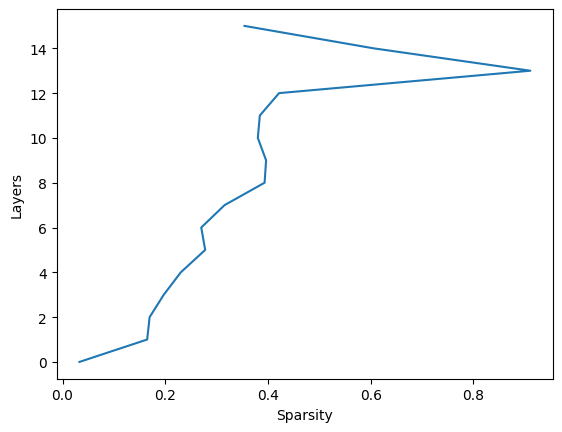

time: 229 ms (started: 2023-09-16 01:52:47 +00:00)


In [38]:
# Plotting Sparsity vs Layers
print('Sparsity: ', sparsity_layer)
print('Layers: ', layer)

plt.plot(sparsity_layer, layer)
plt.ylabel('Layers')
plt.xlabel('Sparsity')

# Structured Pruning

In [39]:
def structured_pruning(model, sparsity_layer):
  prune_model = deepcopy(model)
  prune_model = prune_model.to(device)

  prunable_module_type = (nn.Conv2d, nn.Linear)
  prunable_modules = [ m for m in prune_model.modules() if isinstance(m, prunable_module_type) ]

  strategy = tp.strategy.L1Strategy()
  DG = tp.DependencyGraph().build_dependency(prune_model, example_inputs = torch.randn(1,3,64,64))

  i = 0
  for layer_to_prune in prunable_modules:
    if isinstance( layer_to_prune, nn.Conv2d ):
        prune_fn = tp.prune_conv
    elif isinstance(layer_to_prune, nn.Linear):
        prune_fn = tp.prune_linear

    pruning_idxs = strategy(layer_to_prune.weight, amount = sparsity_layer[i])
    plan = DG.get_pruning_plan( layer_to_prune, prune_fn, pruning_idxs)

    i += 1

    plan.exec()

  return prune_model

time: 975 µs (started: 2023-09-16 01:52:47 +00:00)


In [40]:
stp_model = structured_pruning(ustp_model, sparsity_layer)

time: 1.6 s (started: 2023-09-16 01:52:47 +00:00)


In [41]:
tp.utils.count_params(stp_model)

12169055

time: 4.67 ms (started: 2023-09-16 01:52:48 +00:00)


In [42]:
stp_model.classifier[6].out_features = 100
print(stp_model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 62, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(62, 54, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(54, 107, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(107, 103, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(103, 198, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(198, 185, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(185, 187, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [43]:
stp_model = stp_model.to(device)
acc, loss_stp = evaluate(stp_model, test_dataloader)
print('Accuracy : ',acc , '\tLoss : ', loss_stp)

Accuracy :  6.32 	Loss :  4.487371174393187
time: 6.75 s (started: 2023-09-16 01:52:48 +00:00)


# Fine Tuning

In [44]:
sgd_optimizer = torch.optim.SGD(stp_model.parameters(), lr = 0.001, momentum = 0.9)
epochs = 10

for epoch in range(epochs):
  #Fit model
  fit(stp_model, train_dataloader, sgd_optimizer, None, criterion)

  #Train validation
  trn_acc, trn_lss = evaluate(stp_model, train_dataloader)

  #Test validation
  tst_acc, tst_lss = evaluate(stp_model, test_dataloader)

  print(f'Epoch:{epoch+1:2.0f}\t Train_Loss:{trn_lss:.4f}\t Train_Acc:{trn_acc:.4f}\t Test_Loss:{tst_lss:.4f}\t Test_Acc:{tst_acc:.4f}')

Epoch: 1	 Train_Loss:1.0348	 Train_Acc:69.8880	 Test_Loss:1.2722	 Test_Acc:63.6100
Epoch: 2	 Train_Loss:0.7912	 Train_Acc:76.2580	 Test_Loss:1.1728	 Test_Acc:67.1300
Epoch: 3	 Train_Loss:0.6863	 Train_Acc:79.6740	 Test_Loss:1.1325	 Test_Acc:68.3700
Epoch: 4	 Train_Loss:0.5771	 Train_Acc:82.5980	 Test_Loss:1.1066	 Test_Acc:69.5800
Epoch: 5	 Train_Loss:0.5030	 Train_Acc:84.3320	 Test_Loss:1.1383	 Test_Acc:70.4000
Epoch: 6	 Train_Loss:0.4829	 Train_Acc:85.2020	 Test_Loss:1.1173	 Test_Acc:70.4000
Epoch: 7	 Train_Loss:0.4358	 Train_Acc:86.5200	 Test_Loss:1.1013	 Test_Acc:71.3700
Epoch: 8	 Train_Loss:0.4023	 Train_Acc:87.3040	 Test_Loss:1.1044	 Test_Acc:71.8100
Epoch: 9	 Train_Loss:0.3593	 Train_Acc:88.8380	 Test_Loss:1.1417	 Test_Acc:71.9000
Epoch:10	 Train_Loss:0.3519	 Train_Acc:89.2680	 Test_Loss:1.1592	 Test_Acc:71.7400
time: 16min 29s (started: 2023-09-16 01:52:55 +00:00)


In [45]:
sgd_optimizer = torch.optim.SGD(stp_model.parameters(), lr = 0.0001, momentum = 0.9)
epochs = 5

for epoch in range(epochs):
  #Fit model
  fit(stp_model, train_dataloader, sgd_optimizer, None, criterion)

  #Train validation
  trn_acc, trn_lss = evaluate(stp_model, train_dataloader)

  #Test validation
  tst_acc, tst_lss = evaluate(stp_model, test_dataloader)

  print(f'Epoch:{epoch+11:2.0f}\t Train_Loss:{trn_lss:.4f}\t Train_Acc:{trn_acc:.4f}\t Test_Loss:{tst_lss:.4f}\t Test_Acc:{tst_acc:.4f}')

Epoch:11	 Train_Loss:0.2384	 Train_Acc:92.4600	 Test_Loss:1.1251	 Test_Acc:73.9000
Epoch:12	 Train_Loss:0.2234	 Train_Acc:92.9140	 Test_Loss:1.1379	 Test_Acc:73.9700
Epoch:13	 Train_Loss:0.2137	 Train_Acc:93.1720	 Test_Loss:1.1531	 Test_Acc:73.9600
Epoch:14	 Train_Loss:0.2057	 Train_Acc:93.4140	 Test_Loss:1.1608	 Test_Acc:74.2000
Epoch:15	 Train_Loss:0.1998	 Train_Acc:93.6020	 Test_Loss:1.1720	 Test_Acc:73.8400
time: 8min 16s (started: 2023-09-16 02:09:25 +00:00)


In [46]:
sgd_optimizer = torch.optim.SGD(stp_model.parameters(), lr = 0.00001, momentum = 0.9)
epochs = 5

for epoch in range(epochs):
  #Fit model
  fit(stp_model, train_dataloader, sgd_optimizer, None , criterion)

  #Train validation
  trn_acc, trn_lss = evaluate(stp_model, train_dataloader)

  #Test validation
  tst_acc, tst_lss = evaluate(stp_model, test_dataloader)

  print(f'Epoch:{epoch+16:2.0f}\t Train_Loss:{trn_lss:.4f}\t Train_Acc:{trn_acc:.4f}\t Test_Loss:{tst_lss:.4f}\t Test_Acc:{tst_acc:.4f}')

Epoch:16	 Train_Loss:0.1957	 Train_Acc:93.7400	 Test_Loss:1.1668	 Test_Acc:74.0500
Epoch:17	 Train_Loss:0.1938	 Train_Acc:93.8300	 Test_Loss:1.1616	 Test_Acc:74.1700
Epoch:18	 Train_Loss:0.1959	 Train_Acc:93.7460	 Test_Loss:1.1619	 Test_Acc:74.2000
Epoch:19	 Train_Loss:0.1911	 Train_Acc:93.8760	 Test_Loss:1.1669	 Test_Acc:74.1500
Epoch:20	 Train_Loss:0.1915	 Train_Acc:93.8780	 Test_Loss:1.1670	 Test_Acc:74.1400
time: 8min 15s (started: 2023-09-16 02:17:41 +00:00)


In [47]:
acc, loss = evaluate(stp_model, test_dataloader)
print('Accuracy : ',acc , '\tLoss : ', loss)

Accuracy :  74.14 	Loss :  1.1669672670637725
time: 6.3 s (started: 2023-09-16 02:25:57 +00:00)


In [48]:
torch.save(stp_model, 'pruned_model.pt')

time: 65.5 ms (started: 2023-09-16 02:26:03 +00:00)


In [49]:
import sys
sys.getsizeof('pruned_model.pt')

64

time: 5.89 ms (started: 2023-09-16 02:26:03 +00:00)


In [50]:
import os
pruned_model_size = os.path.getsize('pruned_model.pt')
print("Pruned Model Size is :", pruned_model_size/(1024*1024), "mb")

Pruned Model Size is : 46.44029140472412 mb
time: 3.68 ms (started: 2023-09-16 02:26:03 +00:00)


In [51]:
original_model_size = os.path.getsize('VGG16(SGD)-v1.0')
print("Original VGG16 Model Size is :", original_model_size/(1024*1024), "mb")

Original VGG16 Model Size is : 527.8029336929321 mb
time: 444 µs (started: 2023-09-16 02:26:03 +00:00)
